# Introduction

I try to address here the issue thatRandom Forest does poorly with the faint red galaxies targeted in the Baryon Oscillation Spectroscopic Survey (BOSS). 

I used their target selection query in the SDSS skyserver and obtained 5000 galaxies.

SELECT TOP 5000 
p.objID, p.dered_u, p.err_u, p.dered_g, p.err_g, p.dered_r, p.err_r, p.dered_i, p.err_i,
p.dered_z, p.err_z, s.specObjID, s.z , s.zErr, u.z as photoZ, u.zErr as photoErr
FROM photoprimary as p
inner join specObjAll as s on p.objID = s.bestObjID
inner join Photoz as u ON p.objID = u.objID
WHERE
(dered_r-dered_i) < 2 AND
cmodelmag_i-extinction_i BETWEEN 17.5 AND 19.9 AND
(dered_r-dered_i) - (dered_g-dered_r)/8. > 0.55 AND
fiber2mag_i < 21.7 AND devrad_i < 20. AND
dered_i < 19.86 + 1.60*((dered_r-dered_i) - (dered_g-dered_r)/8. - 0.80) AND
s.class = 'GALAXY'

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import table
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set()
%matplotlib inline

## Loading data and some EDA

In [2]:
filepath= "/home/veroastro/Documents/spectraTypes/data/BOSS/"
data = pd.read_csv(filepath+"BOSS_Skyserver_SQL2_21_2022 4_34_07 PM.csv")


In [3]:

#Scramble the data set so that it is not ordered by spectral class (QSO, galaxy or star) 
data = data.sample(frac=1)

data.head()

,objID,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,class
1623,1237661852547219646,24.69992,1.631441,21.98011,0.114241,20.05033,0.031351,19.15514,0.022078,19.05764,0.074394,7457997099055208448,0.463306,0.000127,0.465259,0.044653,GALAXY
4943,1237678906255475102,24.40717,2.661203,22.98372,0.507767,20.65255,0.107135,19.47228,0.051514,18.79271,0.106028,5126427153580447744,0.606946,0.000292,0.626803,0.036203,GALAXY
855,1237655465384740013,23.06813,0.751502,22.72178,0.248014,20.99964,0.083169,19.71450,0.043041,19.06175,0.087968,7665278681364060160,0.638134,0.000160,0.686860,0.054512,GALAXY
1545,1237661385992110716,22.20933,0.355350,22.92433,0.351393,21.34225,0.119949,19.96121,0.050977,19.29204,0.097708,7686600960354048000,0.727923,0.000247,0.735613,0.053005,GALAXY
2613,1237654627321840603,22.78263,0.674923,21.87284,0.148688,20.24386,0.057256,19.34087,0.037376,18.97801,0.116966,5017152739421214720,0.526365,0.000239,0.509405,0.033041,GALAXY


In [29]:
photoz= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
photozErr = data.loc[(data['photoZ'] >= 0.0)]['photoErr']

print('Mean photoError:', round(np.mean(photozErr), 3))

Mean photoError: 0.04


In [30]:
photozErr.describe()

count    4983.000000
mean        0.039939
std         0.020661
min         0.011766
25%         0.028309
50%         0.034625
75%         0.044654
max         0.183876
Name: photoErr, dtype: float64

In [6]:
print('Mean specError:', round(np.mean(data['zErr']), 4))

Mean specError: 0.0008


The mean value of the spectroscopic errors is 0.0008  while the mean value of the photometric errors is 0.04.

In [8]:

data_clean = data.drop(columns=['specObjID','objID','err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'zErr', 'class', 'photoZ','photoErr'])
data_clean.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
1623,24.69992,21.98011,20.05033,19.15514,19.05764,0.463306
4943,24.40717,22.98372,20.65255,19.47228,18.79271,0.606946
855,23.06813,22.72178,20.99964,19.71450,19.06175,0.638134
1545,22.20933,22.92433,21.34225,19.96121,19.29204,0.727923
2613,22.78263,21.87284,20.24386,19.34087,18.97801,0.526365


In [9]:
data_clean.describe()

,dered_u,dered_g,dered_r,dered_i,dered_z,z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,23.834475,21.943148,20.322268,19.342420,18.910253,0.541412
std,1.369289,0.621962,0.480349,0.387342,0.432116,0.094767
min,18.986700,18.893880,18.313660,17.610480,17.263830,-0.000096
25%,22.767792,21.553583,20.020547,19.128835,18.672770,0.491005
50%,23.675530,21.938810,20.330020,19.388225,18.937880,0.538671
75%,24.899745,22.306520,20.656827,19.606503,19.179132,0.595522
max,28.077370,24.917370,22.267660,20.487410,22.965390,0.994879


In [10]:
def hist_plots( data: pd.DataFrame,
               rows: int,
              cols: int,
              figsize: tuple):
    fig, axes = plt.subplots(rows,cols, figsize=figsize)
    for i, ax in enumerate(axes.flatten()):
        if i < len(data.columns):
            data[sorted(data.columns)[i]].plot.hist(bins=30, ax=ax)
            ax.set_title(f'{sorted(data.columns)[i]} distribution', fontsize=10)
            ax.tick_params(axis='x', labelsize=10)
            ax.tick_params(axis='y', labelsize=10)
            ax.get_yaxis().get_label().set_visible(False)
        else:
            fig.delaxes(ax=ax)
    fig.tight_layout()

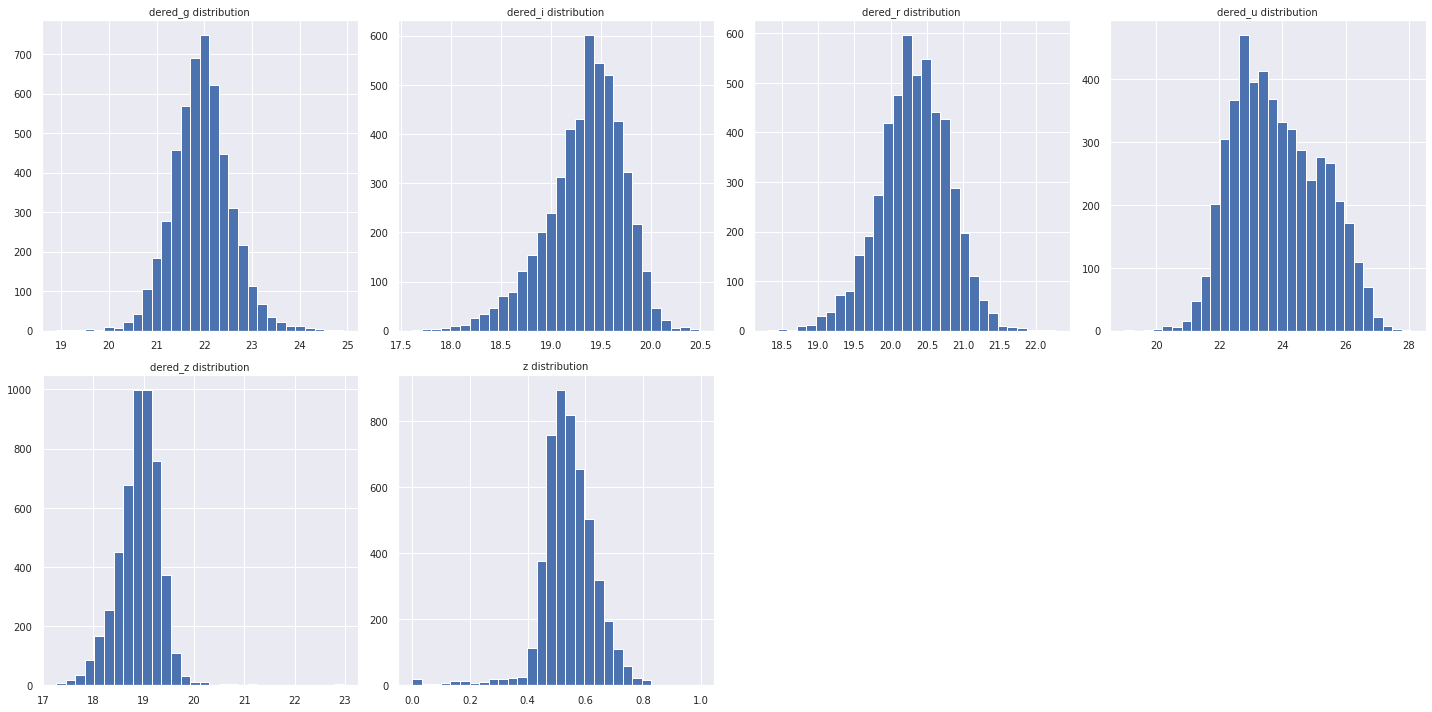

In [11]:
#plots histograms of the column in the dataset
hist_plots(data=data_clean,
          rows=2,
          cols=4,
          figsize=(20,10))
#plt.savefig(filepath+'images/zhistplot.png')

The magnitudes of the bands are in the interquartile ranges (25-75%) between 16-18. The fainter (higher value) sources are mostly outliers of the destributions. Since the distributions are fairly bright, I decided to keep them.

In [12]:
# Creates the X with the atributes and y with the values to determine
cols= data_clean.columns[:-1]
X = data_clean[cols]
y = data_clean['z']


As seen by the graph above, colours (the difference in magnitude between 2 bands) gives no extra information.

## Training models

In [13]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()


LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)}))


In [15]:
error_df

[train    0.004725
 test     0.005599
 dtype: float64]

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

RF = RandomForestRegressor(random_state = 42)

param_grid = {  'bootstrap': [True],
                'max_features': ['log2'], 
                'n_estimators': range(1,400, 40)}

rf= GridSearchCV(RF,
                   param_grid=param_grid)

# Train the model on training data
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)


In [17]:
rf.best_params_ ,rf.best_score_

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 361},
 0.504053500262974)

'bootstrap': True, 'max_features': 'log2', 'n_estimators': 121 best parameters of the random forest regressor. 

In [25]:
# Print out the mean square error
mse_me = mean_squared_error(y_test, predictions)
print('Mean Square Error RF:', round(mean_squared_error(y_test, predictions), 4))

Mean Square Error RF: 0.0049


In [26]:
photoz= data.loc[(data['photoZ'] >= 0.0)]['photoZ']
sZ= data.loc[(data['photoZ'] >= 0.0)]['z']
print(photozErr.shape)
print('Mean Square Error SDSS:', round(mean_squared_error(sZ,photoz), 4))

(4983,)
Mean Square Error SDSS: 0.0046


In [38]:
index = pd.DataFrame(index=X_test.index)
errors = index.join(data, how= 'inner')
prediction = pd.DataFrame(predictions, columns = ['pred'])
errors['pred'] = predictions
errors['pred_err'] = abs(errors['pred'] - errors['z'])

errors.head()

,objID,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,class,pred,pred_err
3314,1237654599956562496,22.34975,0.344992,22.41594,0.179621,20.78720,0.057848,19.73216,0.032588,19.16412,0.063563,5372818364690618368,0.663253,0.000128,0.575898,0.044880,GALAXY,0.593118,0.070135
3910,1237657191444840800,24.12283,1.149156,21.95015,0.094330,20.23592,0.033113,19.39367,0.022830,18.90244,0.057596,4750438705357150208,0.452650,0.000089,0.488651,0.023391,GALAXY,0.479272,0.026621
4479,1237655464312832668,23.44480,1.329041,21.49999,0.113863,19.90540,0.040154,18.97679,0.028552,18.64549,0.084420,7664035133478164480,0.552226,0.000112,0.510545,0.028387,GALAXY,0.512344,0.039882
4279,1237652900760125930,25.11914,1.918722,21.99404,0.168343,20.64066,0.082411,19.66785,0.053728,19.21012,0.158530,8087595603641784320,0.575046,0.000158,0.547353,0.034856,GALAXY,0.564810,0.010236
2537,1237655108907631340,23.24973,0.724324,22.18758,0.159019,20.54857,0.051113,19.64739,0.033683,19.27579,0.079047,7978215087399000064,0.523360,0.000119,0.512550,0.034223,GALAXY,0.517025,0.006335


In [39]:
errors.describe()

,objID,dered_u,err_u,dered_g,err_g,dered_r,err_r,dered_i,err_i,dered_z,err_z,specObjID,z,zErr,photoZ,photoErr,pred,pred_err
count,1.500000e+03,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,1.237659e+18,23.800353,1.032805,21.927932,0.168581,20.308156,0.055347,19.331589,0.033820,18.897543,0.087101,5.808539e+18,0.539542,0.002833,-26.125182,-26.623895,0.541067,0.039802
std,6.110079e+12,1.362115,0.566296,0.629661,0.113753,0.484282,0.021986,0.392928,0.009807,0.430718,0.047732,1.513623e+18,0.098453,0.103931,515.857067,515.831265,0.065889,0.057954
min,1.237649e+18,20.030600,0.089407,19.091750,0.016202,18.460080,0.016181,17.669170,0.011748,17.263830,0.026994,3.400366e+17,-0.000096,0.000000,-9999.000000,-9999.000000,0.137516,0.000032
25%,1.237655e+18,22.704505,0.610777,21.534408,0.103451,20.011633,0.039636,19.127417,0.026597,18.659347,0.065033,4.741895e+18,0.488927,0.000115,0.489710,0.028644,0.493544,0.010440
50%,1.237656e+18,23.674945,0.956623,21.928895,0.138654,20.309630,0.050715,19.380020,0.032417,18.922790,0.080453,5.464139e+18,0.539565,0.000140,0.536277,0.034624,0.538765,0.024424
75%,1.237662e+18,24.842010,1.325959,22.287285,0.193871,20.639318,0.067383,19.594815,0.039712,19.176828,0.100674,7.200504e+18,0.596954,0.000177,0.583504,0.045367,0.586334,0.046351
max,1.237681e+18,27.345650,4.503531,24.917370,1.099768,22.267660,0.198734,20.487410,0.076327,22.804640,1.025291,1.248068e+19,0.819564,4.025382,0.994135,0.179934,0.746144,0.604351


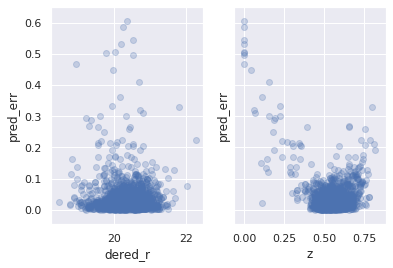

In [35]:
# Creates subplots with 2 graphs.
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot( x="dered_r", y="pred_err", data=errors, fit_reg=False,scatter_kws={'alpha':0.25}, ax=ax1)
sns.regplot( x="z", y="pred_err", data=errors, fit_reg=False, scatter_kws={'alpha':0.25}, ax=ax2)

plt.show()

The first image shows that there is no correlation between the predicted z error (the absolute difference between the spectroscopic redshift and the derived photometric redshift). Similar to the results in determining_redshift_less_bias, few galaxies around 20 mag hive higher predicted z error. 

Whith the second image we see that the highest errors (>0.2) they are either very close to 0 or close to 0.75. But the highest errors are those with close to o redshift. 

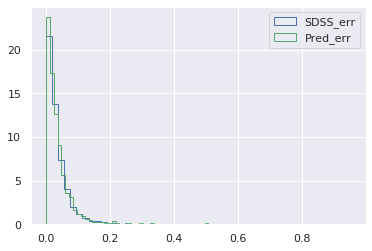

In [37]:
# Plots the density histogram for the predicted z error and the SDSS photometric error
plt.hist(abs(photoz-sZ), bins=50, density = True,histtype= 'step')
plt.hist(errors['pred_err'],color = 'g', bins=50, density = True ,histtype= 'step')
labels= [ "SDSS_err", "Pred_err"]
plt.legend( labels)
plt.show()

The histograms show that there is not much difference between the predicted and the SDSS photometric errors.

## Conclusion

For the 5000 Galaxies obtained using the BOSS target selection in SDSS, the predicted error using the Random Forest algorithm is the same as the SDSS photometric redshift. 

The predicted error is neither dependent on the actual redshift or on the dered_r magnitude. 